In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import urllib.request
import os

base_url = 'http://download.tensorflow.org/models/object_detection/'
file_name = 'ssd_mobilenet_v1_coco_2018_01_28.tar.gz'

url = base_url + file_name

urllib.request.urlretrieve(url, file_name)

os.listdir()

In [ ]:
import tarfile
import shutil

dir_name = file_name[0:-len('.tar.gz')]

if os.path.exists(dir_name):
    shutil.rmtree(dir_name)
  
tarfile.open(file_name, 'r:gz').extractall('./')

In [3]:
frozen_graph = os.path.join(dir_name, 'frozen_inference_graph.pb')

with tf.gfile.FastGFile(frozen_graph,'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

W0715 11:21:30.541446 4599915968 deprecation.py:323] From <ipython-input-3-4a48092c59e6>:3: FastGFile.__init__ (from tensorflow.python.platform.gfile) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.gfile.GFile.


In [ ]:
from zipfile import ZipFile

with ZipFile("bottles.zip", "r") as zipObj:
    zipObj.extractall()

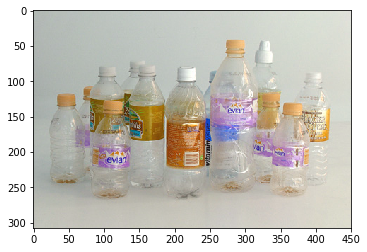

In [4]:
input_images = []

image = cv.imread("bottles/bottles4.jpg")
plt.imshow(image)
input_images.append(image)

In [5]:
outputs = ('num_detections',
           'detection_classes',
           'detection_scores',
           'detection_boxes')

In [6]:
labels = {}

with open("labels.txt", "r") as f:
    for name in f:
        key, _, value = name.partition(':')
        value, _, _ = value.partition('\n')
        labels[key] = value

In [7]:
with tf.Session() as sess:
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name="")

    detections = sess.run([sess.graph.get_tensor_by_name(f'{op}:0') for op in outputs],
        feed_dict={ 'image_tensor:0': input_images })

In [8]:
num_detections = detections[0]
detection_classes = detections[1]
detection_scores = detections[2]
detection_boxes = detections[3]

In [9]:
num_detections[0]

9.0

In [10]:
for classes in detection_classes[0]:
    if classes != 1:
        print(labels[str(int(classes))])

 bottle
 bottle
 bottle
 bottle
 bottle
 bottle
 bottle
 bottle
 bottle


In [11]:
for i in range(int(num_detections[0])):
    print(detection_scores[0][i])

0.9490663
0.82028687
0.81337094
0.7484953
0.68266624
0.66551447
0.6513449
0.4305061
0.38700038


Number of confident detections: 8


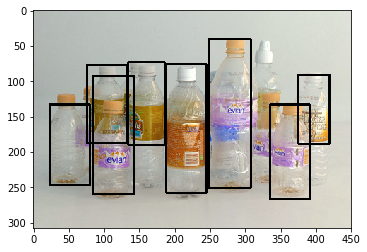

In [12]:
image_copy = np.copy(input_images[0])
image_box = np.copy(input_images[0])

height = image_copy.shape[0]
width = image_copy.shape[1]

cropped_images = []
cropped_count = 0

for x in range(0,int(num_detections)):
    if detection_scores[0][x] >= 0.4:
        left = int(width*detection_boxes[0][x][1])
        top = int(height*detection_boxes[0][x][0])
        right = int(width*detection_boxes[0][x][3])
        bottom = int(height*detection_boxes[0][x][2])
        
        cv.rectangle(image_box,
                     (left, top),
                     (right, bottom),
                     [0,0,0],
                     thickness=2)
        
        cropped = image_copy[top:bottom, left:right]
        cv.imwrite("{}{}".format(labels[str(int(detection_classes[0][x]))], x+1) + '.png', cropped)
        cropped_images.append(cropped)
        cropped_count += 1

if cropped_count == 0:
    print("Use another image")
else:
    plt.imshow(image_box)
    print("Number of confident detections: {}".format(cropped_count))

In [13]:
[os.remove(images) for images in os.listdir() if images.endswith('.png')]

[None, None, None, None, None, None, None, None]

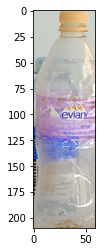

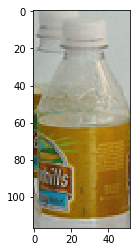

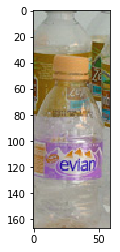

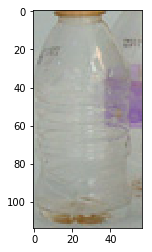

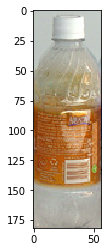

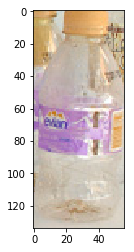

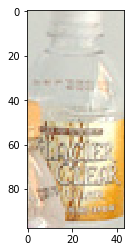

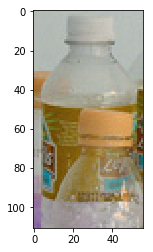

In [14]:
for images in cropped_images:
    plt.imshow(images)
    plt.show()

In [15]:
import keras
from keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False)

base_model.trainable = False

Using TensorFlow backend.
/Users/waynechim/anaconda3/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '
W0715 11:22:49.911725 4599915968 deprecation_wrapper.py:119] From /Users/waynechim/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0715 11:22:49.913434 4599915968 deprecation_wrapper.py:119] From /Users/waynechim/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:529: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0715 11:22:49.919618 4599915968 deprecation_wrapper.py:119] From /Users/waynechim/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_

In [16]:
from keras.models import Sequential
from keras.layers import *

model = Sequential([base_model,
                    Conv2D(32, 1, activation='relu'),
                    Dropout(0.2),
                    GlobalAveragePooling2D(),
                    Dense(3, activation='softmax')])

W0715 11:23:08.436575 4599915968 deprecation.py:506] From /Users/waynechim/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3721: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 mobilenetv2_1.00_224
1 conv2d_1
2 dropout_1
3 global_average_pooling2d_1
4 dense_1


In [ ]:
with ZipFile('trashnet.zip', 'r') as zipObj:
    zipObj.extractall()

In [18]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input

datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                             rescale=1./255,
                             validation_split=0.2)

train_generator = datagen.flow_from_directory('trashnet',
                                              target_size=(224,224),
                                              color_mode='rgb',
                                              batch_size=32,
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

val_generator = datagen.flow_from_directory('trashnet',
                                            target_size=(224,224),
                                            color_mode='rgb',
                                            batch_size=16,
                                            class_mode='categorical',
                                            subset='validation',
                                            shuffle=True)

Found 180 images belonging to 3 classes.
Found 45 images belonging to 3 classes.


In [19]:
from keras.optimizers import Adam

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    epochs=10,
                    validation_data=val_generator)

W0715 11:23:24.682003 4599915968 deprecation_wrapper.py:119] From /Users/waynechim/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0715 11:23:24.899266 4599915968 deprecation.py:323] From /Users/waynechim/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
6/6 [==============================] - 24s 4s/step - loss: 1.3507 - acc: 0.4237 - val_loss: 1.2718 - val_acc: 0.3333
Epoch 2/10
6/6 [==============================] - 24s 4s/step - loss: 0.7570 - acc: 0.7133 - val_loss: 1.4302 - val_acc: 0.3333
Epoch 3/10
6/6 [==============================] - 23s 4s/step - loss: 0.5366 - acc: 0.8211 - val_loss: 1.3288 - val_acc: 0.3333
Epoch 4/10
6/6 [==============================] - 18s 3s/step - loss: 0.3513 - acc: 0.8948 - val_loss: 1.4530 - val_acc: 0.3333
Epoch 5/10
6/6 [==============================] - 18s 3s/step - loss: 0.2252 - acc: 0.9526 - val_loss: 1.5900 - val_acc: 0.3333
Epoch 6/10
6/6 [==============================] - 19s 3s/step - loss: 0.1598 - acc: 0.9790 - val_loss: 1.7249 - val_acc: 0.3333
Epoch 7/10
6/6 [==============================] - 21s 3s/step - loss: 0.1398 - acc: 0.9790 - val_loss: 1.9504 - val_acc: 0.3333
Epoch 8/10
6/6 [==============================] - 18s 3s/step - loss: 0.1206 - acc: 0.9684 - val_loss: 1

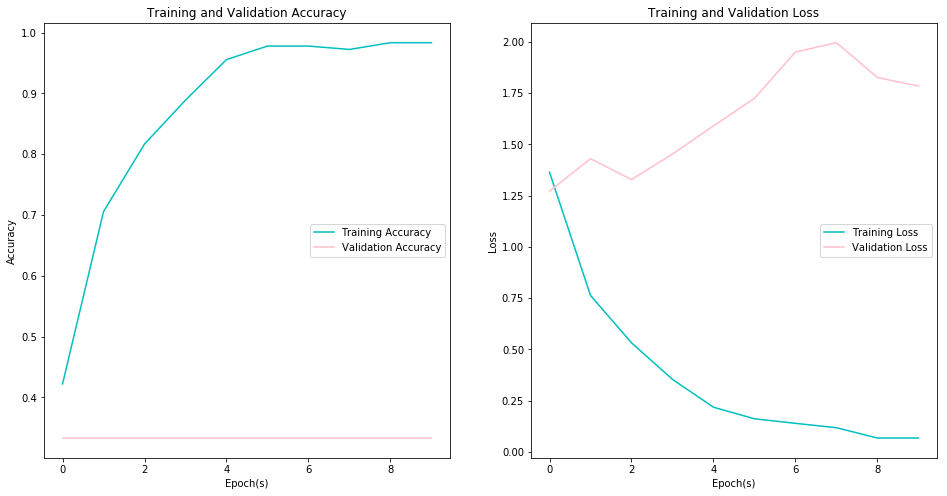

In [20]:
import seaborn as sns

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss= history.history['val_loss']

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 8))
g1 = sns.lineplot(x=range(10),
                  y=acc,
                  label='Training Accuracy',
                  color='c',
                  ax=ax1)
g2 = sns.lineplot(x=range(10),
                  y=val_acc,
                  label='Validation Accuracy',
                  color='pink',
                  ax=ax1)
g1.set_title('Training and Validation Accuracy')
g1.set_xlabel('Epoch(s)')
g1.set_ylabel('Accuracy')
g1.legend(loc='center right')

g3 = sns.lineplot(x=range(10),
                  y=loss,
                  label='Training Loss',
                  color='c',
                  ax=ax2)
g4 = sns.lineplot(x=range(10),
                  y=val_loss,
                  label='Validation Loss',
                  color='pink',
                  ax=ax2)
g3.set_title('Training and Validation Loss')
g3.set_xlabel('Epoch(s)')
g3.set_ylabel('Loss')
g3.legend(loc='center right')

plt.show()

In [23]:
for images in cropped_images:
    print(images.shape)

(210, 60, 3)
(117, 52, 3)
(167, 59, 3)
(114, 57, 3)
(182, 57, 3)
(134, 56, 3)
(98, 44, 3)
(111, 56, 3)


In [24]:
predictions = []

for images in cropped_images:
    test_image = images
    test_image = test_image/255.
    test_image = np.expand_dims(test_image, axis=0)
  
    prediction = model.predict(test_image)
    predictions.append(prediction)
    
predictions

[array([[1.5551728e-05, 9.9998450e-01, 4.3635300e-08]], dtype=float32),
 array([[1.06850246e-04, 9.99892950e-01, 2.71484140e-07]], dtype=float32),
 array([[1.1933169e-05, 9.9998808e-01, 7.4106978e-09]], dtype=float32),
 array([[1.5438884e-05, 9.9998438e-01, 6.3571619e-08]], dtype=float32),
 array([[3.952593e-04, 9.996038e-01, 9.404487e-07]], dtype=float32),
 array([[7.6495571e-04, 9.9923444e-01, 5.8333922e-07]], dtype=float32),
 array([[6.9328626e-03, 9.9306691e-01, 2.7404565e-07]], dtype=float32),
 array([[8.9862051e-06, 9.9999106e-01, 1.2905545e-08]], dtype=float32)]

In [25]:
print(train_generator.class_indices)

{'non-recyclable': 0, 'organic': 1, 'recyclable': 2}


In [26]:
len(predictions)

8

Organic: 0.9999845027923584


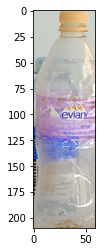

Organic: 0.9998929500579834


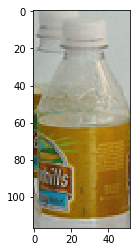

Organic: 0.9999880790710449


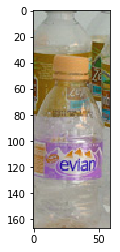

Organic: 0.9999843835830688


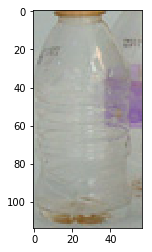

Organic: 0.999603807926178


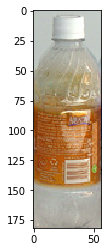

Organic: 0.9992344379425049


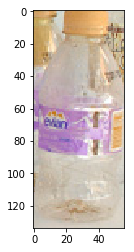

Organic: 0.9930669069290161


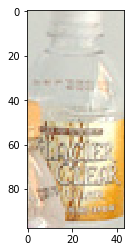

Organic: 0.9999910593032837


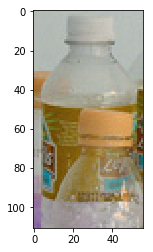

In [27]:
classes = ['Non-recyclable', 'Organic', 'Recyclable']

for i in range(len(predictions)):
    likely = predictions[i][0][0]
    likely_index = 0
    
    for j in range(len(predictions[i][0])):
        if predictions[i][0][j] > likely:
            likely = predictions[i][0][j]
            likely_index = j
    
    if likely >= 0.9:
        print('{}: {}'.format(classes[likely_index], likely))
    else:
        print('{}: {}'.format(classes[0], predictions[i][0][0]))
        print('{}: {}'.format(classes[1], predictions[i][0][1]))
        print('{}: {}'.format(classes[2], predictions[i][0][2]))
    plt.imshow(cropped_images[i])
    plt.show()